In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def pairwise_distances(X):
  return np.sum((X[None, :] - X[:, None])**2, 2) 

In [ ]:
def p_conditional(distances, sigmas):
  e = np.exp(-distances / (2 * np.square(sigmas.reshape((-1, 1)))))
  np.fill_diagonal(e, 0)
  e += 1e-8
  return e / e.sum(axis= 1).reshape([-1, 1])

In [ ]:
def perp(conditional_matrix):
  ent = -np.sum(conditional_matrix * np.log2(conditional_matrix), 1)
  return 2 ** ent

In [ ]:
def binary_search(func, goal, tol=1e-10, max_iters=1000, lowb=1e-20, uppb=10000):
    for _ in range(max_iters):
        guess = (uppb + lowb) / 2.
        val = func(guess)

        if val > goal:
            uppb = guess
        else:
            lowb = guess

        if np.abs(val - goal) <= tol:
            return guess

    return guess

In [ ]:
def find_sigmas(distances, perplexity):
  sigmas = np.zeros(distances.shape[0])
  for i in range(distances.shape[0]):
    func = lambda sig: perp(p_conditional(distances[i:i + 1, :], np.array([sig])))
    sigmas[i] = binary_search(func, perplexity)
  return sigmas

In [ ]:
def q_joint(y):
  distances = pairwise_distances(y)
  nom = 1 / (1 + distances)
  np.fill_diagonal(nom, 0)
  return nom / np.sum(np.sum(nom))

In [ ]:
def gradient(P, Q, y):
    (n, no_dims) = y.shape
    pq_diff = P - Q
    y_diff = np.expand_dims(y,1) - np.expand_dims(y,0)

    dists = pairwise_distances(y)
    aux = 1 / (1 + dists)
    return 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux,2)).sum(1)

In [ ]:
def m(t):
    return 0.5 if t < 250 else 0.8

In [ ]:
def p_joint(X, perp):
    N = X.shape[0]
    dists = pairwise_distances(X)
    sigmas = find_sigmas(dists, perp)
    p_cond = p_conditional(dists, sigmas)
    return (p_cond + p_cond.T) / (2. * N)

In [ ]:
def tsne(X, ydim=2, T=1000, l=500, perp=30):
    N = X.shape[0]
    P = p_joint(X, perp)

    Y = []
    y = np.random.normal(loc=0.0, scale=1e-4, size=(N,ydim))
    Y.append(y); Y.append(y)

    for t in range(T):
        Q = q_joint(Y[-1])
        grad = gradient(P, Q, Y[-1])
        y = Y[-1] - l*grad + m(t)*(Y[-1] - Y[-2])
        Y.append(y)
        if t % 10 == 0:
            Q = np.maximum(Q, 1e-12)
    return y

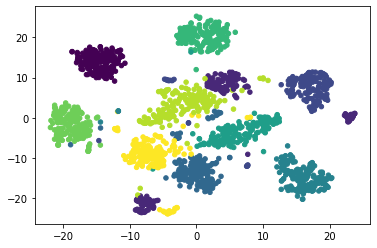

In [ ]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
res = tsne(X, T=1000, l=200, perp=40)
plt.scatter(res[:, 0], res[:, 1], s=20, c=y)
plt.show()

In [ ]:
def plot2d(data, labels, perps=[30], iters=400):
    np.random.seed(123)
    f, axs = plt.subplots(1, len(perps)+1, figsize=(12,24))
    f.tight_layout()
    axs[0].axis('off')
    axs[0].scatter(data[:, 0], data[:, 1], c=labels)
    axs[0].title.set_text('Original')
    axs[0].axis('square')

    for i, perp in enumerate(perps):
        axs[i+1].axis('off')
        res = tsne(data, T=iters, l=200, perp=perp)
        axs[i+1].scatter(res[:, 0], res[:, 1], s=20, c=labels)
        axs[i+1].title.set_text(f'Perplexity: {perp}')
        axs[i+1].axis('square')
    plt.show()

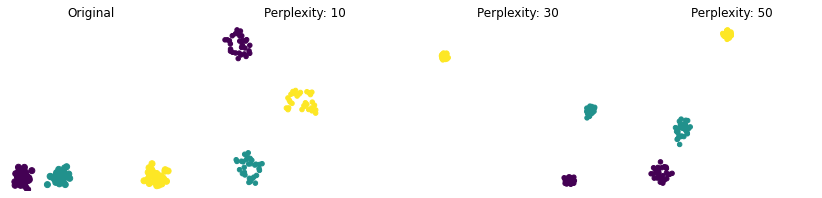

In [ ]:
size = 30
d1 = np.random.multivariate_normal([-5, 0], [[2,0],[0,2]], size=size)
d2 = np.random.multivariate_normal([5, 0], [[2,0],[0,2]], size=size)
d3 = np.random.multivariate_normal([30, 0], [[2,0],[0,2]], size=size)
d = np.concatenate((d1, d2, d3), axis=0)
l = [0] * size + [1] * size + [2] * size
plot2d(d, l, perps=[10,30,50])

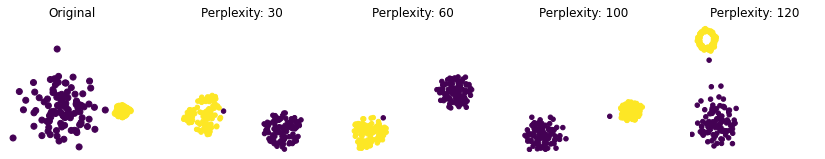

In [ ]:
size = 100
d1 = np.random.multivariate_normal([-8, 0], [[20,0],[0,20]], size=size)
d2 = np.random.multivariate_normal([8, 0], [[0.5,0],[0,0.5]], size=size)
d = np.concatenate((d1, d2), axis=0)
l = [0] * size + [1] * size
plot2d(d, l, perps=[30,60,100,120])